# 🚀Unlock Warp-Speed AI: Deploying DeepSeek-R1 with vLLM V1 engine and Building an AI-Powered Office Assistant

Imagine firing up a 60-billion+ parameter reasoning beast—DeepSeek-R1—on AMD’s flagship MI300X GPUs and watching it spit out 200+ tokens per second without breaking a sweat. Now imagine doing it with a single command-line, no CUDA drama, no driver nightmares, and with vLLM v0.9.2’s brand-new V1 Engine that rewrites the latency-throughput playbook.

In this hands-on deep-dive you will:

#### Witness the V1 vs V0 smackdown
By running the following multi-round conversation system demo, user can do the side-by-side live benchmarks, to show the real-time latency  and throughputs why the V1 Engine’s new scheduler and paged-attention kernels deliver the higher QPS and lower TTFT.


#### Deploy DeepSeek-R1 in production
From quantized safetensors to OpenAI-compatible /v1/chat/completions endpoints—Auto-scaling, continuous batching, and KV-cache offloading all pre-tuned for MI300’s 128 GB HBM3.

#### Craft an AI office sidekick
Transform the live DeepSeek-R1 instance into a native Word & Excel copilot that sits inside your desktop apps, instantly condensing multi-page documents —turning hours of paperwork into minutes of conversation.

Let’s fire up the MI300X and dive in!


## Prerequisites

This tutorial was developed and tested using the following setup. 

#### Operating system

* **Ubuntu 22.04/24.04**: Ensure your system is running Ubuntu version 22.04 or 24.04.

#### Hardware

* **AMD Instinct™ GPUs**: This tutorial was tested on an AMD Instinct MI300X GPU. Ensure you are using an AMD Instinct GPU or compatible hardware with ROCm support and that your system meets the [official requirements](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/reference/system-requirements.html).

#### Software

* **ROCm 6.3 or 6.4**: Install and verify ROCm by following the [ROCm install guide](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/install/quick-start.html). After installation, confirm your setup using:

    ``` bash
    rocm-smi
    ```

    This command lists your AMD GPUs with relevant details, similar to the image below.

   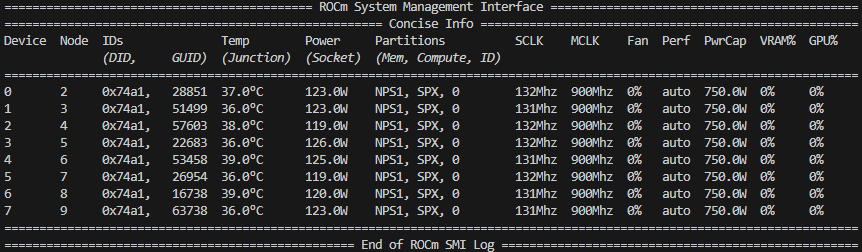


* **Docker**: Ensure Docker is installed and configured correctly. Follow the Docker installation guide for your operating system.

   **Note**: Ensure the Docker permissions are correctly configured. To configure permissions to allow non-root access, run the following commands:

   ``` bash
   sudo usermod -aG docker $USER
   newgrp docker
   ```

   Verify Docker is working correctly:

   ``` bash
   docker run hello-world
   ```

## DEMO-01: multi-turn question-answering, Deepseek-R1 V1 engine vs V0 Engine.

## Pull and launch the docker via the terminal 
#### 1. Open a new terminal window and pull the docker
   
   docker pull rocm/vllm-dev:nightly_0624_rc2_0624_rc2_20250620
   
#### 2. Launch the docker:

   
docker run -it --rm \
  --cap-add=SYS_PTRACE \
  -e SHELL=/bin/bash \
  --network=host \
  --security-opt seccomp=unconfined \
  --device=/dev/kfd \
  --device=/dev/dri \
  -v /:/workspace \
  --group-add video \
  --ipc=host \
  --name vllm_V1_demo_01 \
  rocm/vllm-dev:nightly_0624_rc2_0624_rc2_20250620

  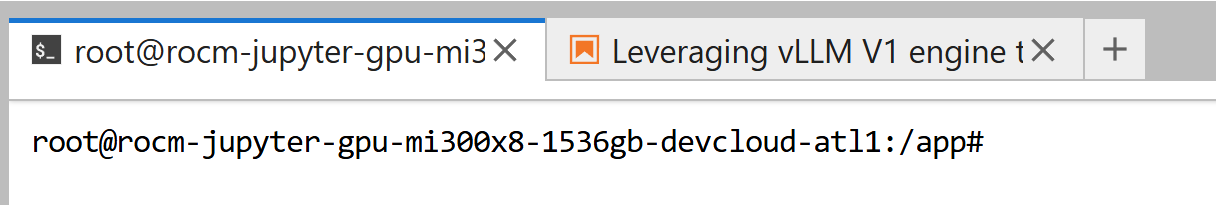


#### 3. Install and launch Jupyter

Inside the Docker container, install Jupyter using the following command:

``` bash
pip install jupyter
```

Start the Jupyter server:

``` bash
jupyter-lab --ip=0.0.0.0 --port=8888 --no-browser --allow-root
```

**Note**: Ensure port `8888` is not already in use on your system before running the above command. If it is, you can specify a different port by replacing `--port=8888` with another port number, for example, `--port=8890`.


#### Once done, please switch back to the jupyter notebook GUI and continue running the following steps.


In [ ]:
Clean the pip installation cache space, to avoid potential compilation issues.

In [4]:
!pip cache purge

Files removed: 0 (0 bytes)


#### Next, let’s introduce the performance testing toolkit designed for vLLM. 

This toolkit simulates realistic multi-user conversation scenarios, where new users continuously join while existing users exit. Currently, it focuses on multi-turn question answering: the script multi-round-qa.py launches numerous parallel user sessions, each engaging in multiple rounds of dialogue with the model. This setup provides a clear view of serving latency and overall throughput.

The script’s high-level flow is illustrated below: 

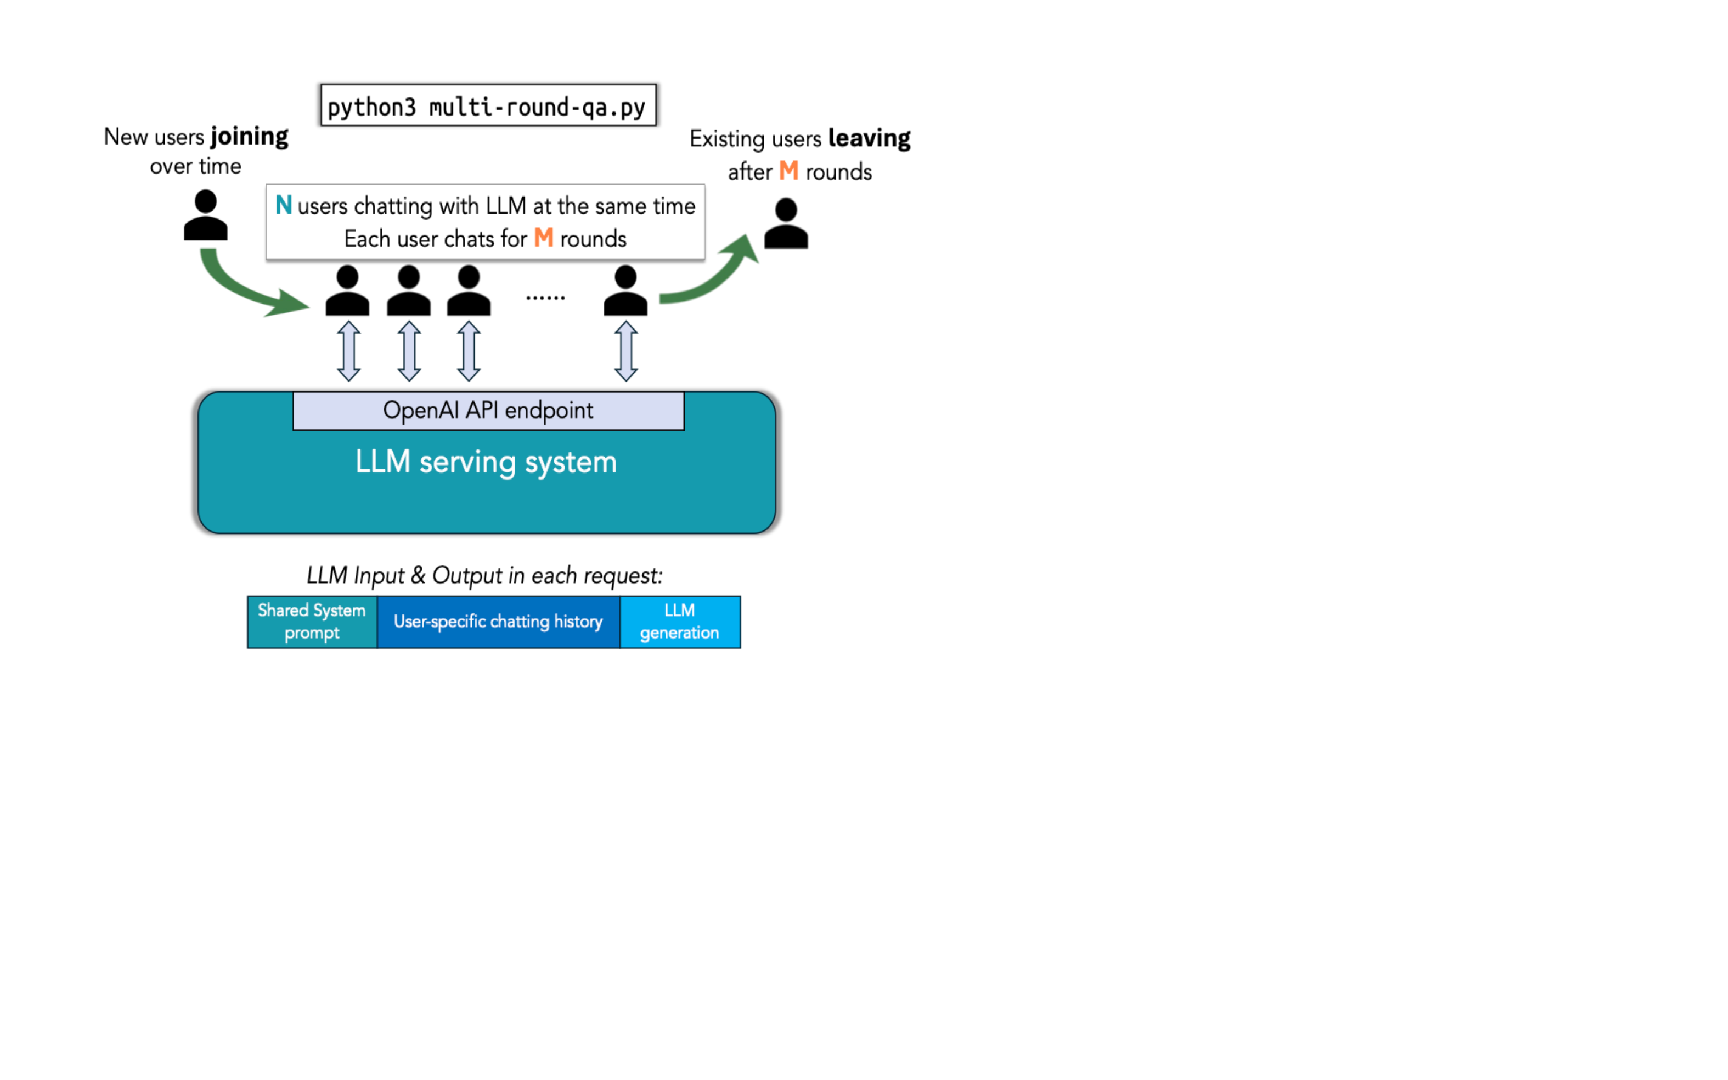

#### It replays a realistic multi-turn QA pattern:

• Each user holds a stateful chat session (conversation history is carried forward).

• Every turn the user asks a follow-up question whose length grows with the accumulated context.

• The script stresses the engine on latency (TTFT, ITL) and throughput (effective QPS) while the KV cache is being reused, evicted, or off-loaded.

Start to test it now!

In [5]:
%%bash
cd /app 
git clone https://github.com/vllm-project/production-stack.git
cd /app/production-stack/benchmarks/multi-round-qa
pip install -r requirements.txt

Cloning into 'production-stack'...


#### To run the multi-round QA benchmark, run the following cell to continue:

#### 1. Prepare the huggingface models
#### Install the huggingface cli

pip install -U "huggingface_hub[cli]"

#### Download the models 

huggingface-cli download --resume-download --local-dir-use-symlinks False deepseek-ai/DeepSeek-R1 --local-dir  DeepSeek-R1



In [ ]:
%%bash
pip install -U "huggingface_hub[cli]"
cd /workspace/
mkdir models && cd models
mkdir Deepseek-R1
cd ..
huggingface-cli download --resume-download --local-dir-use-symlinks False deepseek-ai/DeepSeek-R1 --local-dir  DeepSeek-R1

#### 2. Deepseek V1 engine:  Start a new terminal to run the Deepseek V1 engine: 

#### Copy and paste the following command to the terminal window:

SAFETENSORS_FAST_GPU=1 VLLM_ROCM_USE_AITER=1 VLLM_USE_V1=1  vllm serve /workspace/home/models/DeepSeek-R1 -tp 8 --max-model-len 32768 --block-size 1 --max_seq_len_to_capture 32768 --no-enable-prefix-caching --max-num-batched-tokens 32768 --gpu-memory-utilization 0.95 --trust-remote-code -tp 8 --max-model-len 32768 --block-size 1 --max_seq_len_to_capture 32768 --no-enable-prefix-caching --max-num-batched-tokens 32768 --gpu-memory-utilization 0.95 --trust-remote-code --port 8000 --trust-remote-code

#### Output
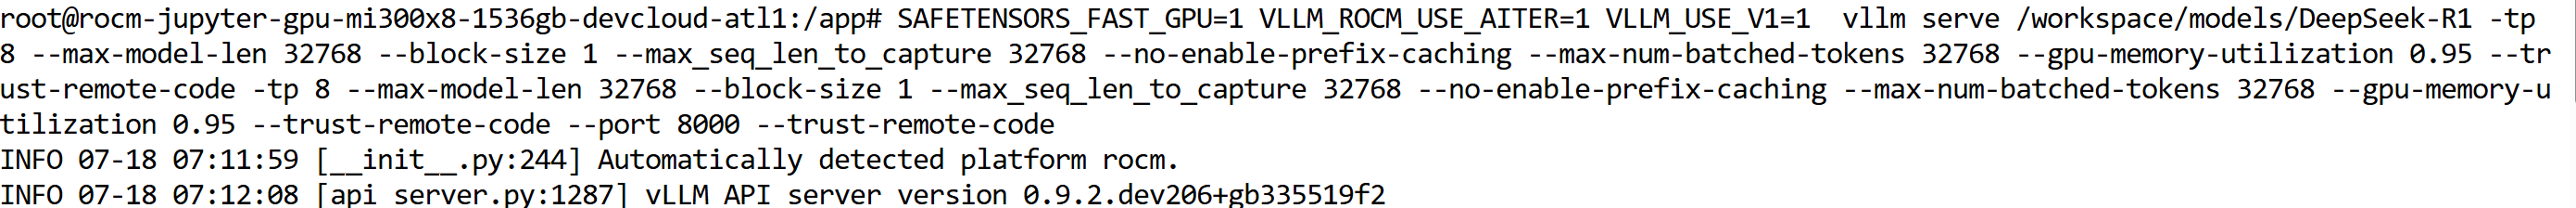




#### When the Deepseek V1 engine is running successfully, go back to the jupyter notebook and continue running the cells below:

#### Output

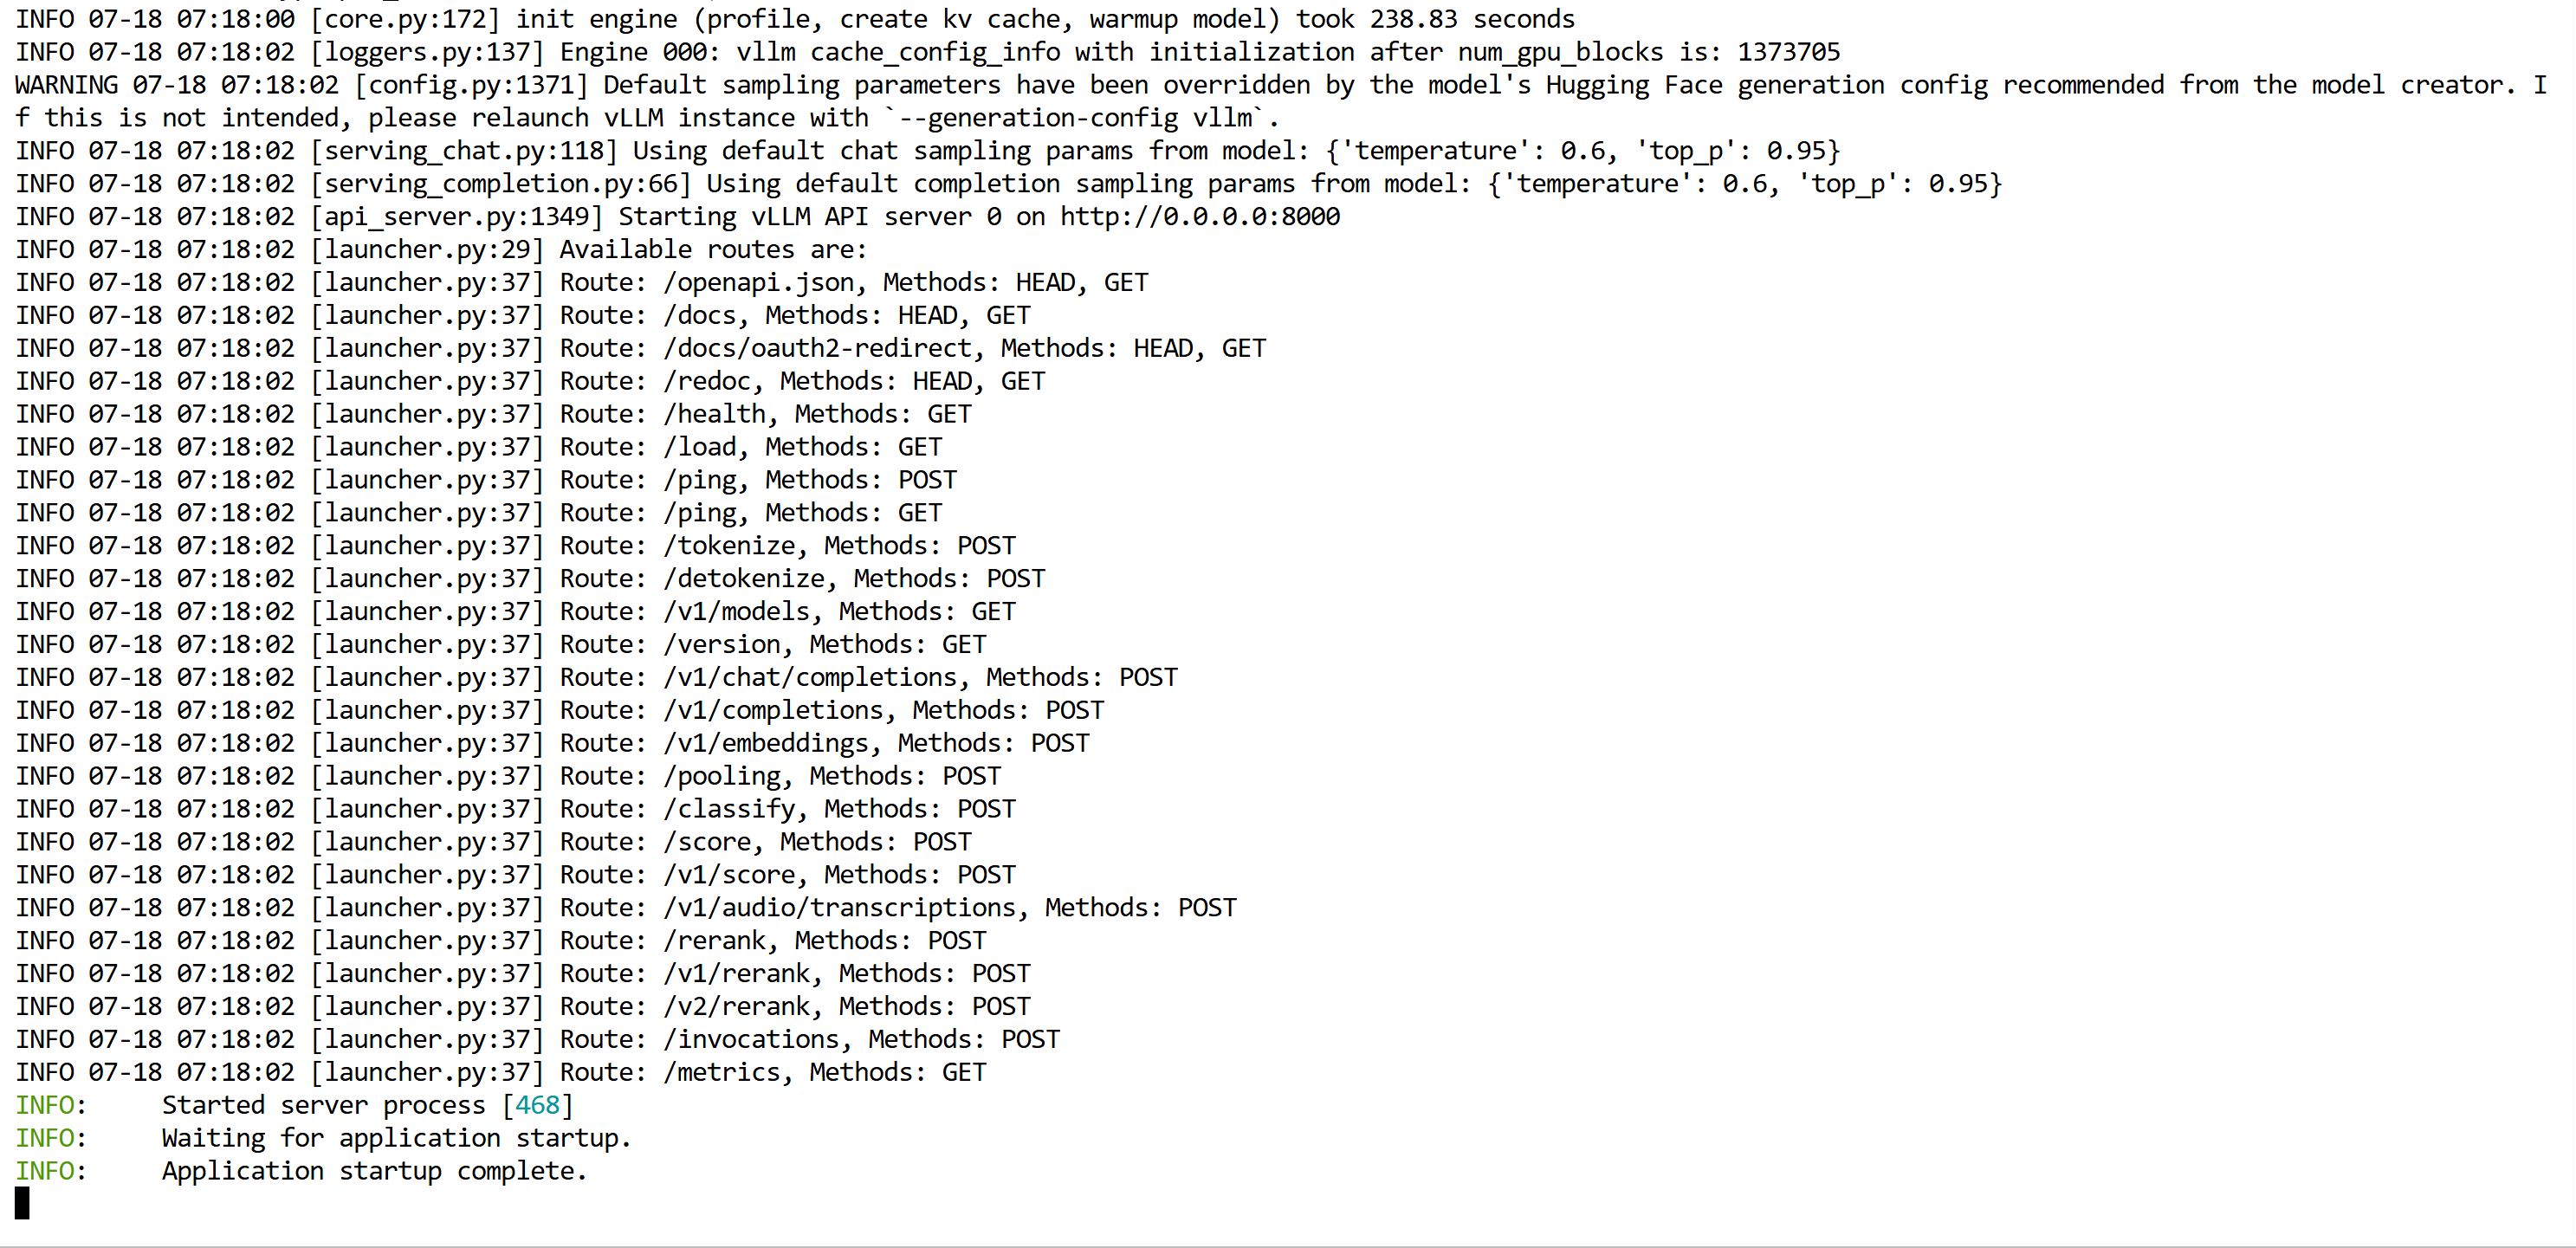


In [23]:
%%bash
cd /app/production-stack/benchmarks/multi-round-qa

In [27]:
!python3 multi-round-qa.py \
    --num-users 10 \
    --num-rounds 5 \
    --qps 0.5 \
    --shared-system-prompt 1000 \
    --user-history-prompt 2000 \
    --answer-len 100 \
    --model /workspace/models/DeepSeek-R1 \
    --base-url http://localhost:8000/v1

[2025-07-18 07:44:02,972] DEBUG: Starting the asyncio loop (utils.py:90:AsyncLoopWrapper)
[2025-07-18 07:44:02,972] INFO: Warming up the engine (multi-round-qa.py:535:__main__)
[2025-07-18 07:44:03,062] INFO: Waiting for 10 tasks to finish (utils.py:67:AsyncLoopWrapper)
[2025-07-18 07:44:14,693] INFO: Gap between users: 8.0 secs.
Gap between user reqs: 20.0 secs.
Expected length of user session: 80.0 secs. (multi-round-qa.py:356:__main__)
[2025-07-18 07:44:14,694] INFO: Joined a new user 11, now active users: 11 (multi-round-qa.py:425:__main__)
[2025-07-18 07:44:14,694] INFO: Removing 1 finished sessions, now active users: 10 (multi-round-qa.py:407:__main__)
[2025-07-18 07:44:22,706] INFO: Joined a new user 12, now active users: 11 (multi-round-qa.py:425:__main__)
[2025-07-18 07:44:28,013] INFO: Removing 1 finished sessions, now active users: 10 (multi-round-qa.py:407:__main__)
[2025-07-18 07:44:30,717] INFO: Joined a new user 13, now active users: 11 (multi-round-qa.py:425:__main__)
[

## The live performance of V1 engine:

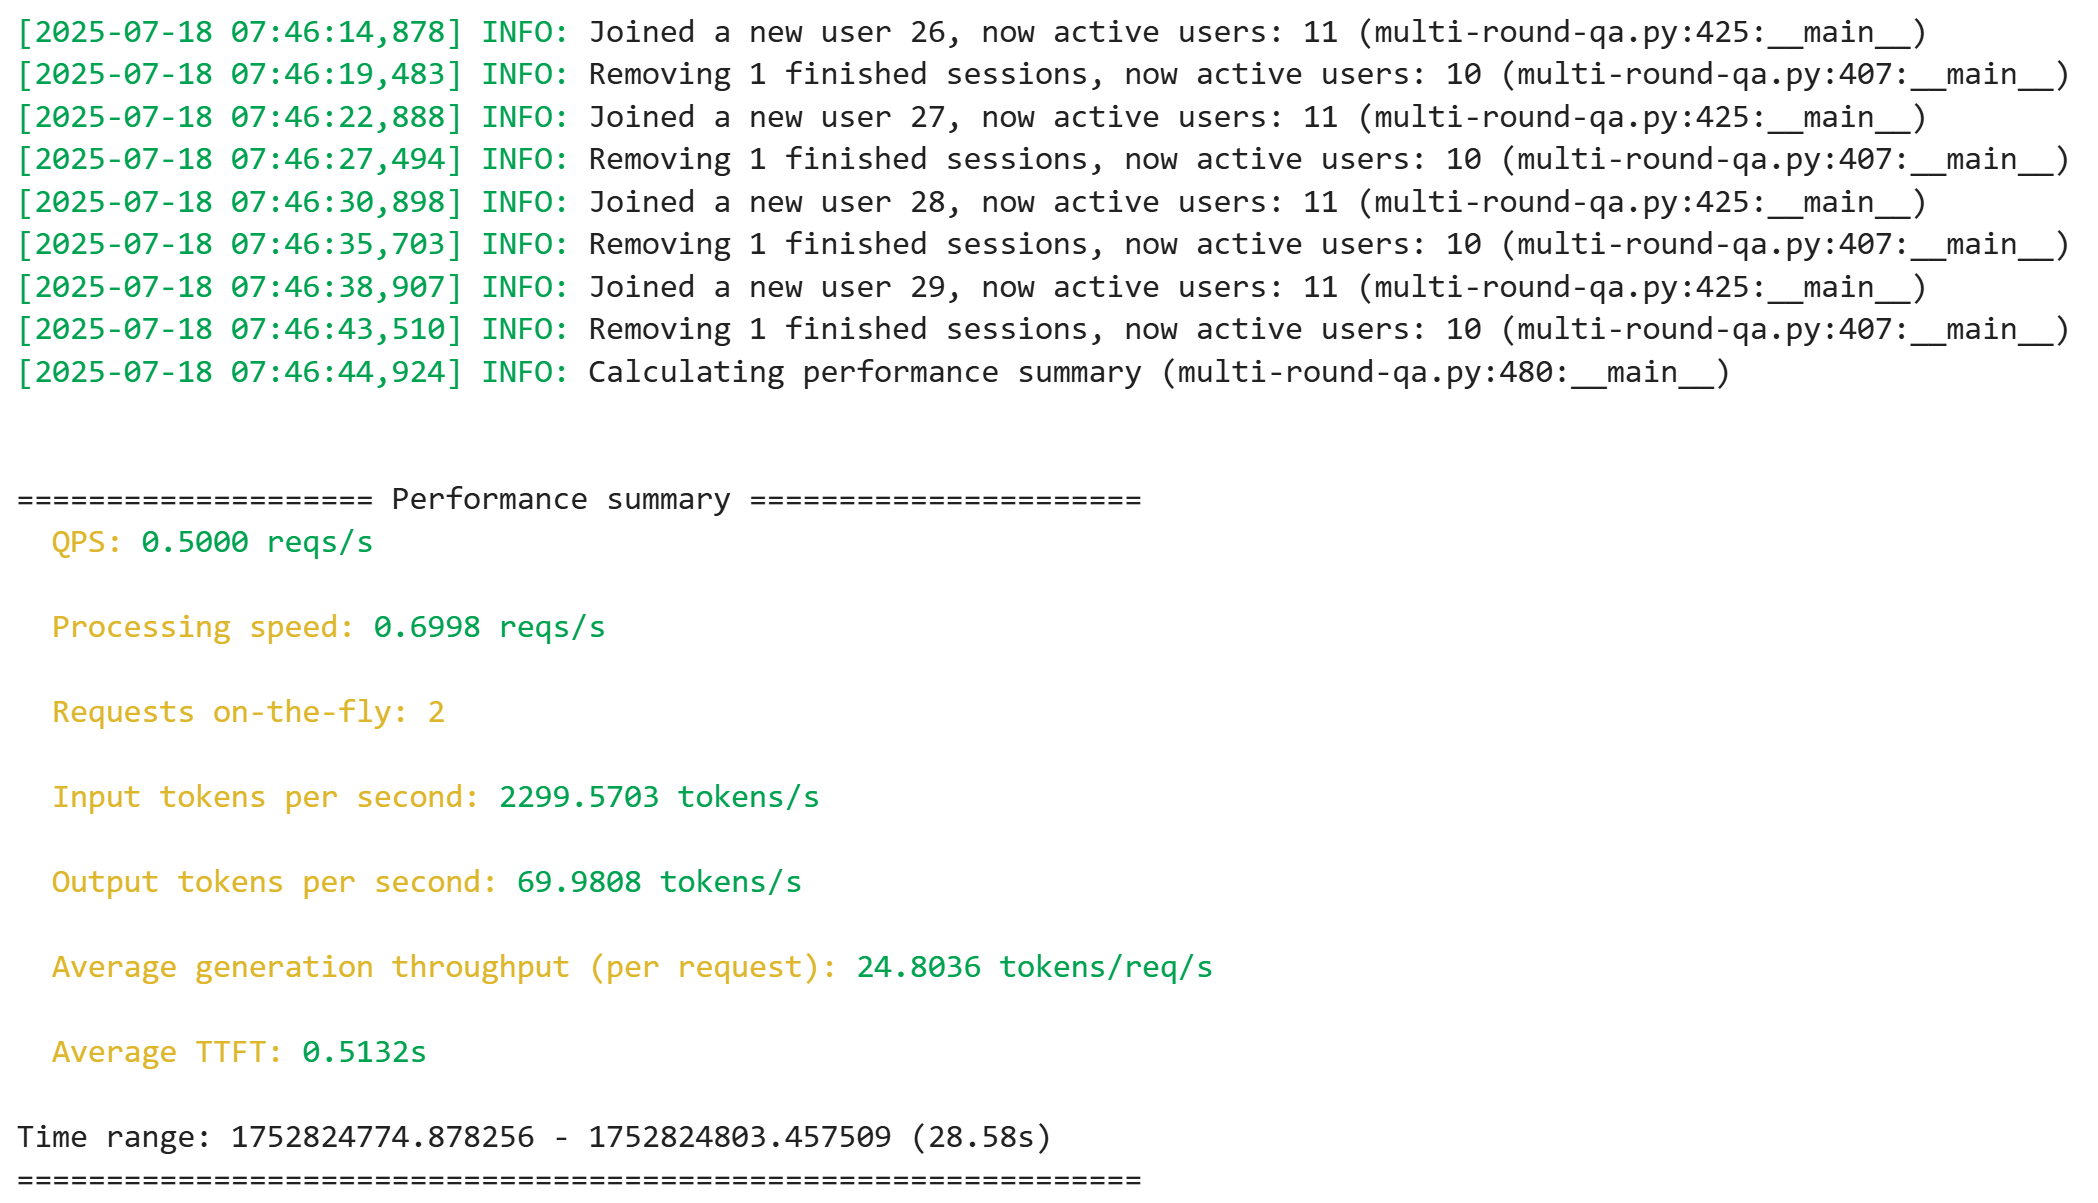



####  Since the live demo will be running without a stop, you can watch as long as you wish. 
#### Click 'Interrupt the kernel' to stop the current running process,and then continue running the V0 engine.

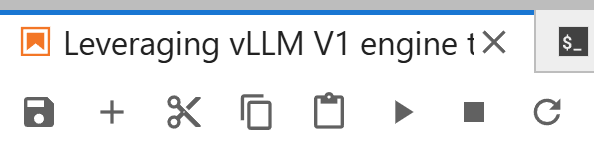


#### 3. Deepseek V0 engine:  In the same terminal, type Ctrl +C to stop the V1 engine, and then run the  V0 engine: 

#### 
#### Copy and paste the following command to the terminal window:

SAFETENSORS_FAST_GPU=1 VLLM_ROCM_USE_AITER=1 VLLM_USE_V1=0  vllm serve /workspace/models/DeepSeek-R1 -tp 8 --max-model-len 32768 --block-size 1 --max_seq_len_to_capture 32768 --no-enable-prefix-caching --max-num-batched-tokens 32768 --gpu-memory-utilization 0.95 --trust-remote-code -tp 8 --max-model-len 32768 --block-size 1 --max_seq_len_to_capture 32768 --no-enable-prefix-caching --max-num-batched-tokens 32768 --gpu-memory-utilization 0.95 --trust-remote-code --port 8000 --trust-remote-code

#### Output
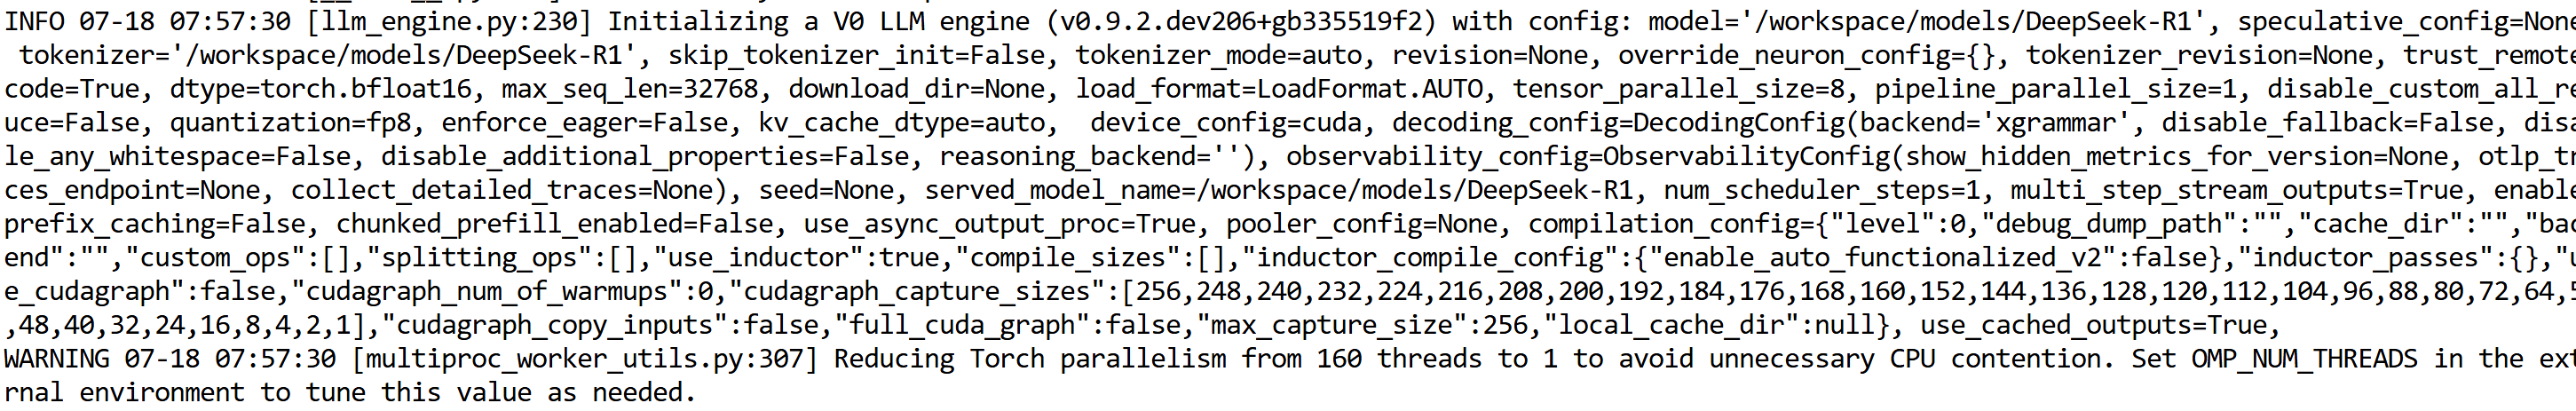



#### When the Deepseek V0 engine is running successfully, go back to the jupyter notebook and continue running the cells below:

#### Output

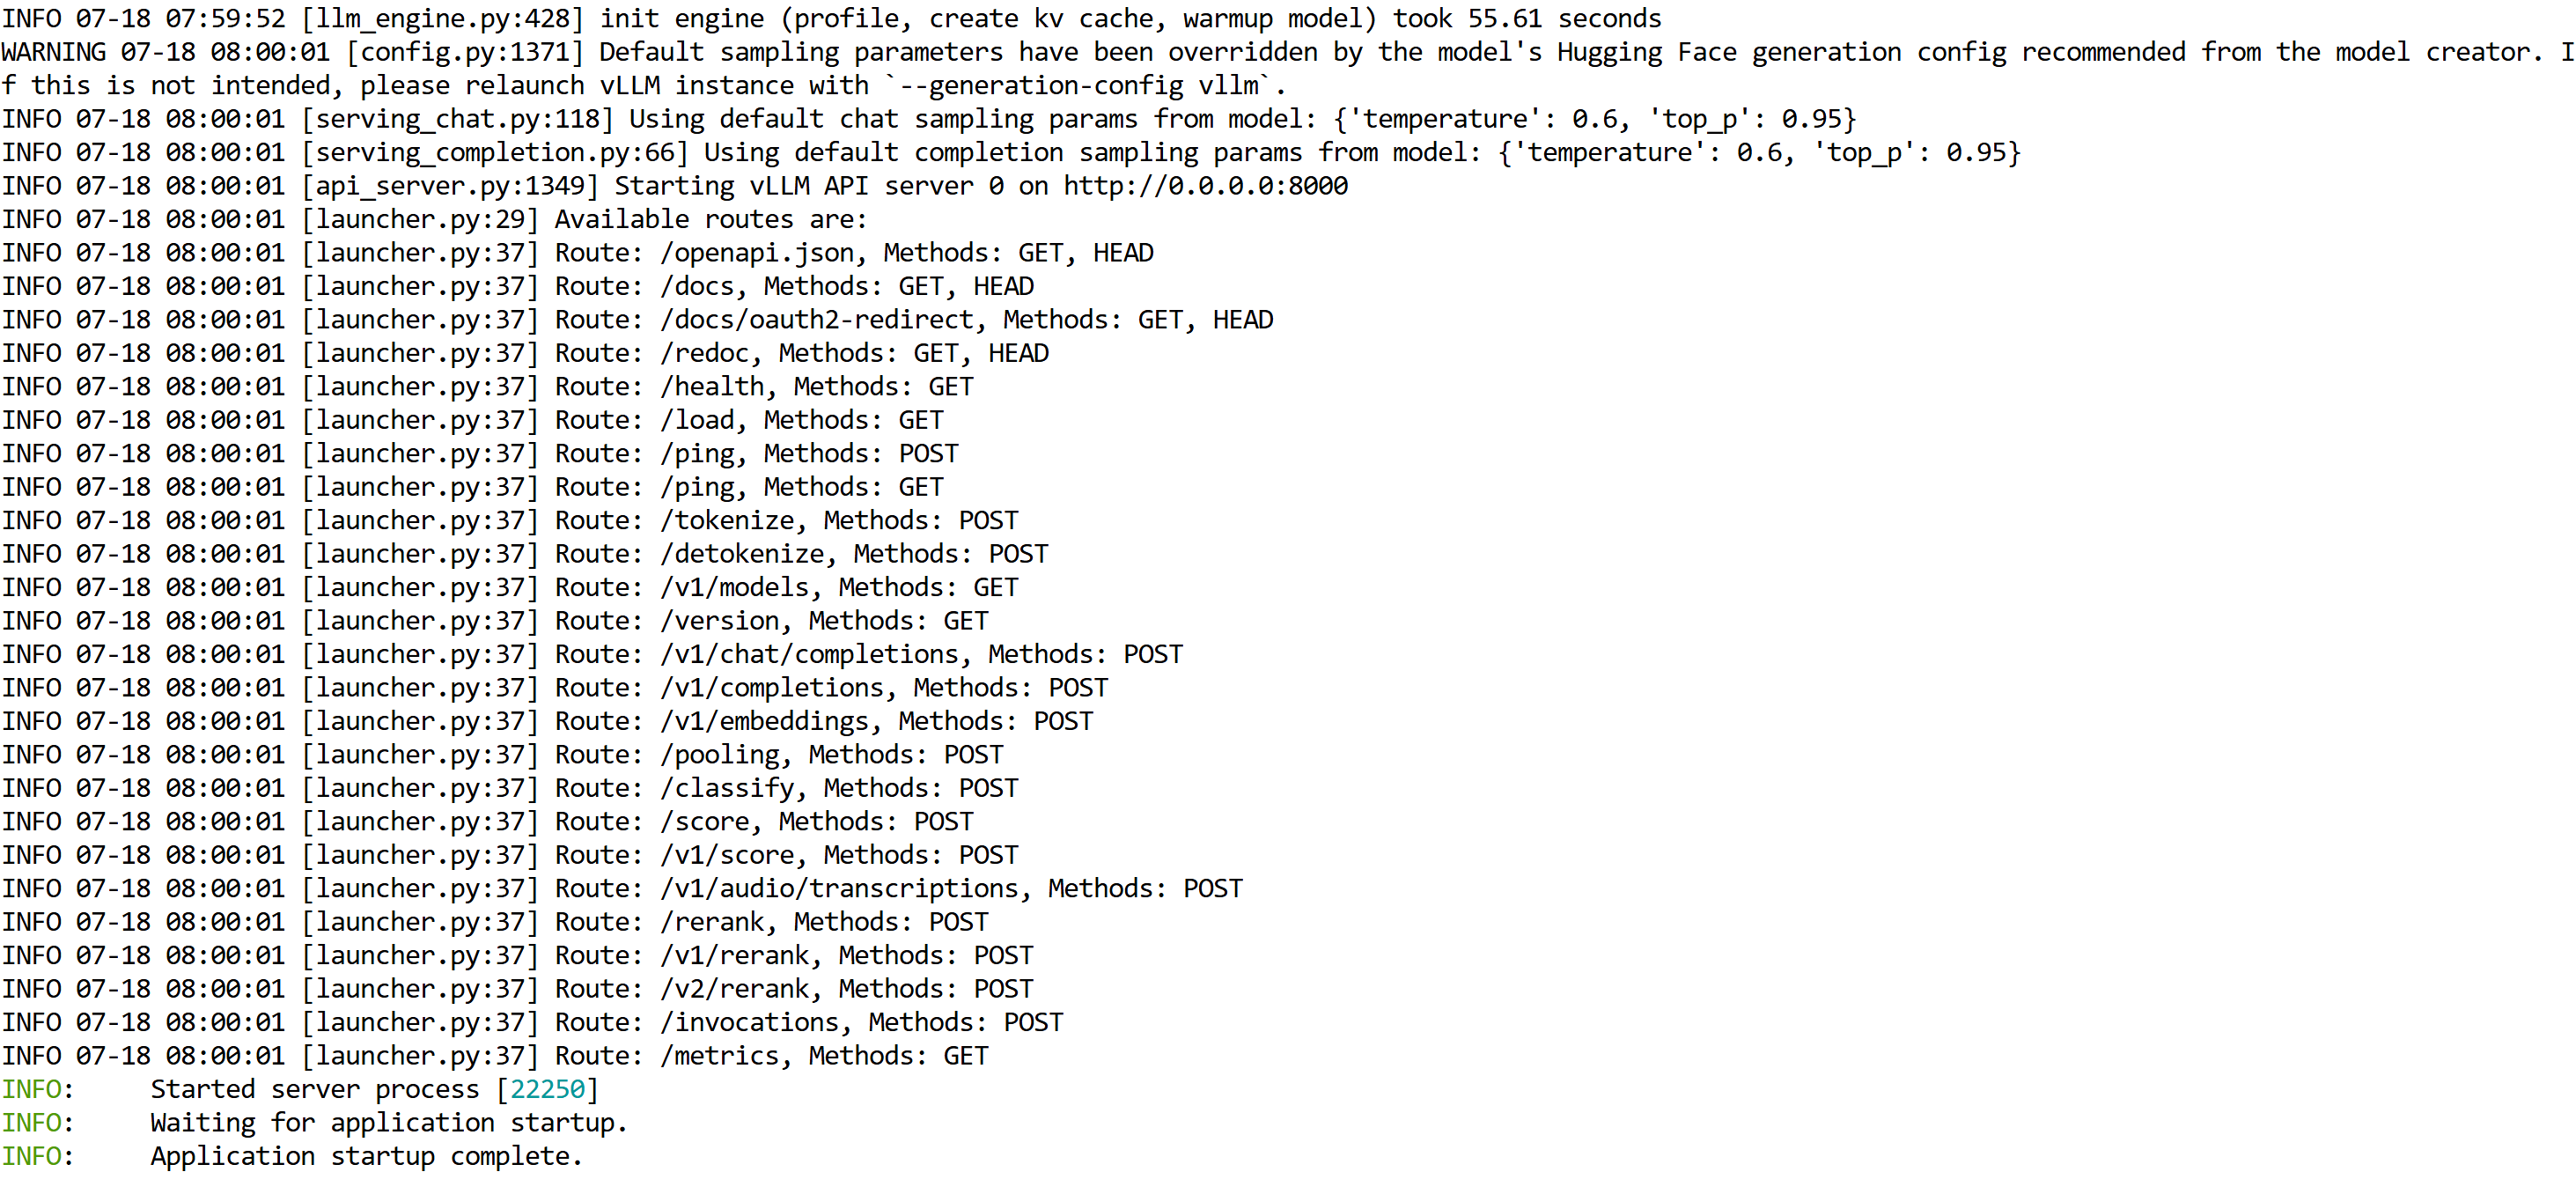


In [28]:
!python3 multi-round-qa.py \
    --num-users 10 \
    --num-rounds 5 \
    --qps 0.5 \
    --shared-system-prompt 1000 \
    --user-history-prompt 2000 \
    --answer-len 100 \
    --model /workspace/models/DeepSeek-R1 \
    --base-url http://localhost:8000/v1

[2025-07-18 08:02:14,121] DEBUG: Starting the asyncio loop (utils.py:90:AsyncLoopWrapper)
[2025-07-18 08:02:14,122] INFO: Warming up the engine (multi-round-qa.py:535:__main__)
[2025-07-18 08:02:14,223] INFO: Waiting for 10 tasks to finish (utils.py:67:AsyncLoopWrapper)
[2025-07-18 08:02:18,014] INFO: Gap between users: 8.0 secs.
Gap between user reqs: 20.0 secs.
Expected length of user session: 80.0 secs. (multi-round-qa.py:356:__main__)
[2025-07-18 08:02:18,014] INFO: Joined a new user 11, now active users: 11 (multi-round-qa.py:425:__main__)
[2025-07-18 08:02:18,014] INFO: Removing 1 finished sessions, now active users: 10 (multi-round-qa.py:407:__main__)
[2025-07-18 08:02:26,027] INFO: Joined a new user 12, now active users: 11 (multi-round-qa.py:425:__main__)
[2025-07-18 08:02:29,931] INFO: Removing 1 finished sessions, now active users: 10 (multi-round-qa.py:407:__main__)
[2025-07-18 08:02:34,038] INFO: Joined a new user 13, now active users: 11 (multi-round-qa.py:425:__main__)
[

#### The live performance of V0 engine:

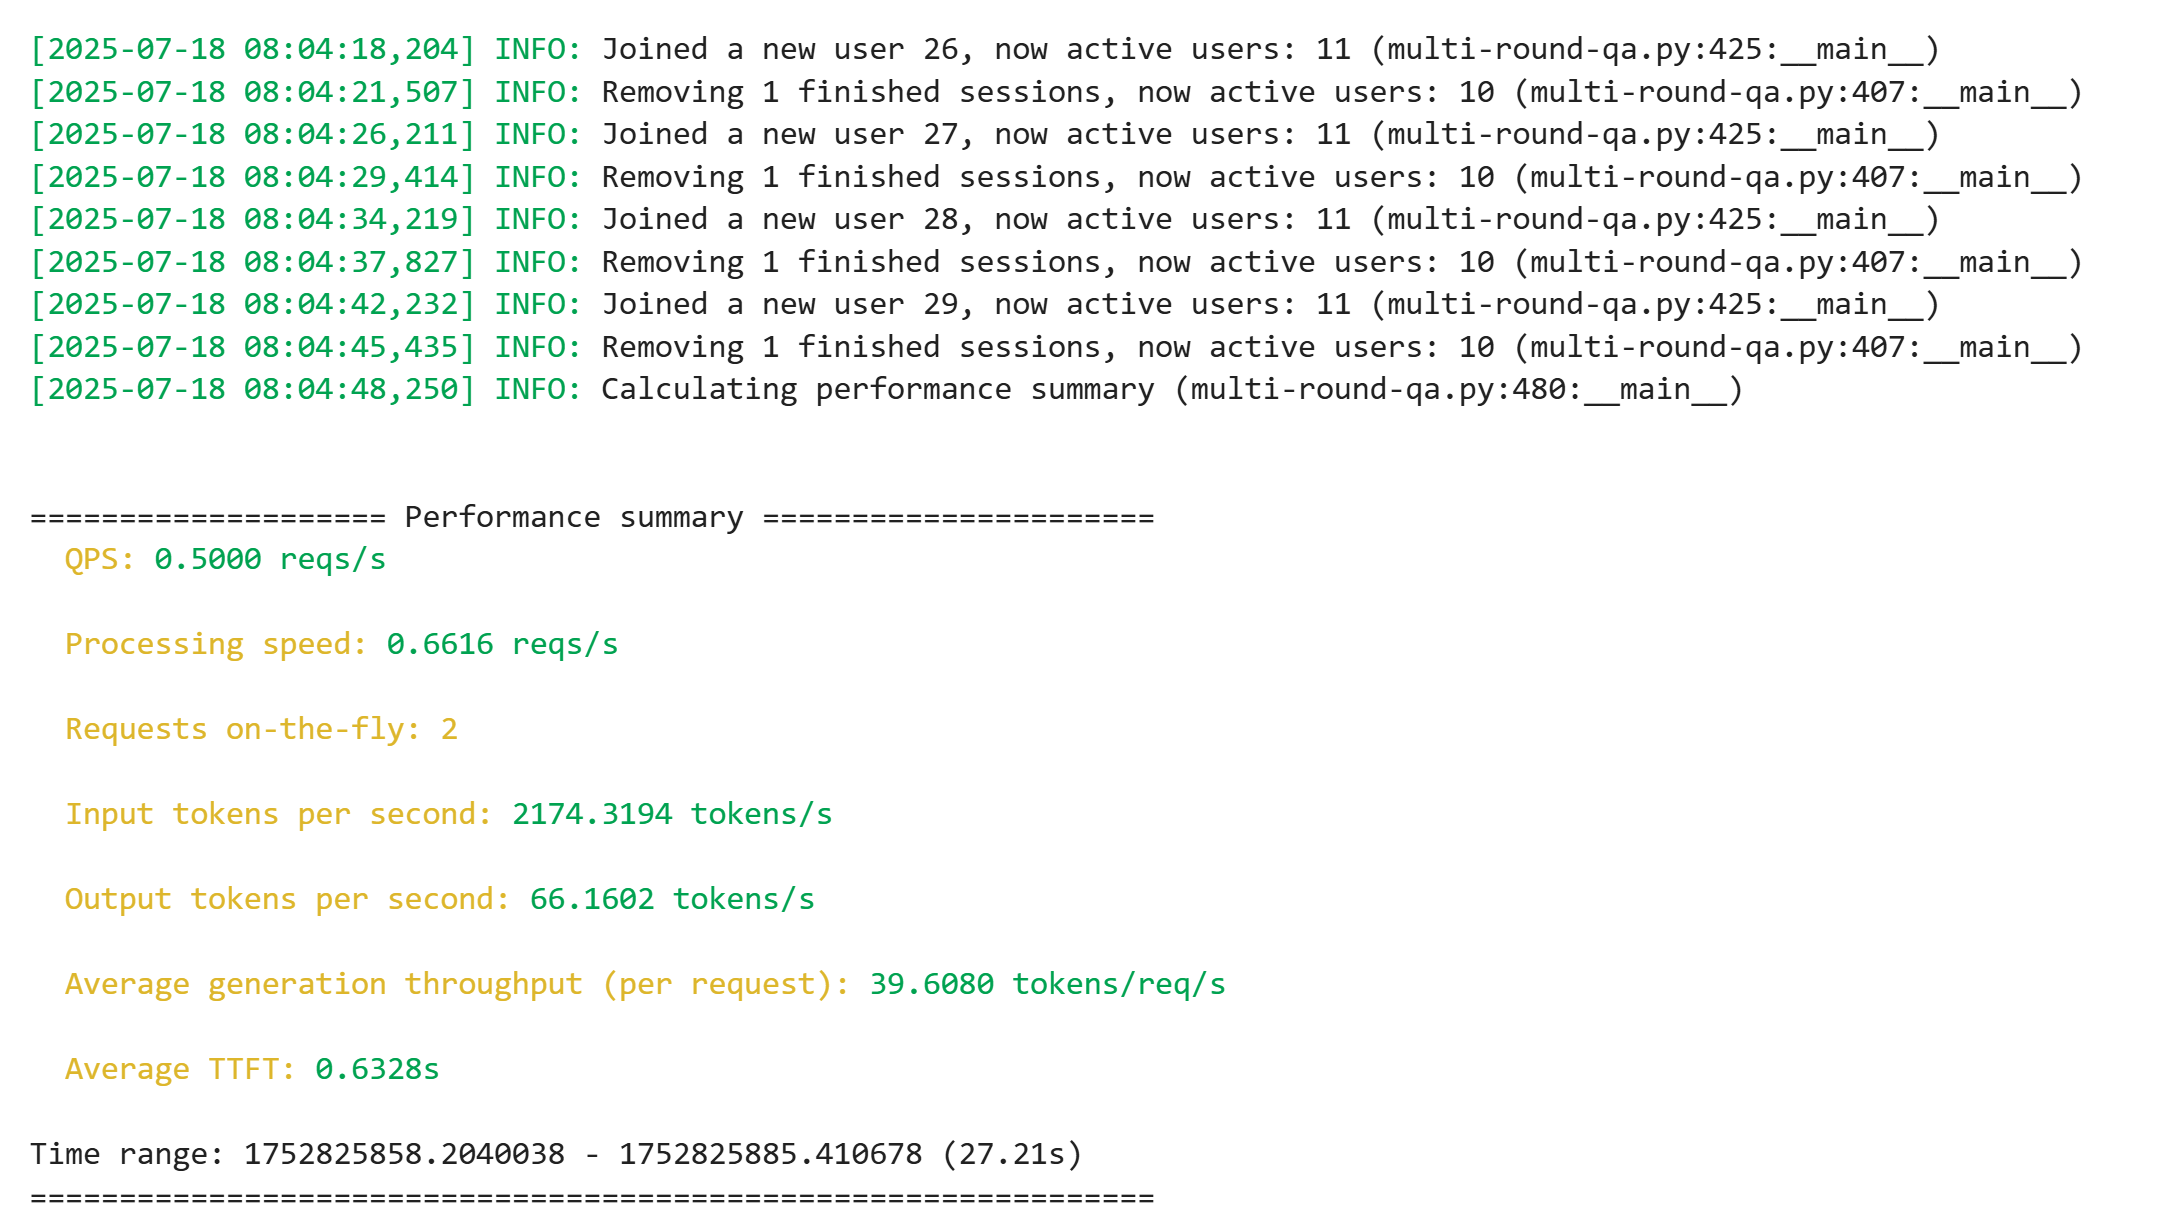



####  Since the live demo will be running without a stop, you can watch as long as you wish. 
#### Click 'Interrupt the kernel' to stop the current running process,and then switch back to the terminal window, type Ctrl + C to stop the V0 engine process. 




## DEMO-02

## In this demo we launch an AI-powered office assistant: simply drag-and-drop .docx or .txt files, and the containerized tool instantly returns concise, high-quality summaries—no setup beyond docker run.

#### Prerequisite: Confirm that DEMO-01 has been fully terminated before proceeding.



#### Start a new terminal to serve the Deepseek-R1 model in the vllm online serving mode.

#### Copy and paste the following command to the terminal window:

SAFETENSORS_FAST_GPU=1 VLLM_ROCM_USE_AITER=1 VLLM_USE_V1=1  vllm serve /workspace/home/models/DeepSeek-R1 -tp 8 --max-model-len 32768 --block-size 1 --max_seq_len_to_capture 32768 --no-enable-prefix-caching --max-num-batched-tokens 32768 --gpu-memory-utilization 0.95 --trust-remote-code -tp 8 --max-model-len 32768 --block-size 1 --max_seq_len_to_capture 32768 --no-enable-prefix-caching --max-num-batched-tokens 32768 --gpu-memory-utilization 0.95 --trust-remote-code --port 8000 --trust-remote-code



#### When the Deepseek V1 engine is running successfully, go back to the jupyter notebook and continue running the cells below:







#### Install the required libs. And import required libs.





In [29]:
#Install the required libs.
%pip install python-docx openai ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [python-docx] [python-docx]
Note: you may need to restart the kernel to use updated packages.


In [44]:
#import required libs
import io
import os
from pathlib import Path
import textwrap

import docx
import ipywidgets as widgets
from openai import OpenAI

import ipywidgets as widgets
from IPython.display import display, clear_output
from io import BytesIO
import docx

In [45]:
#Define the vllm configurations for the openai endpoint

vllm_base = os.getenv("VLLM_ENDPOINT", "http://localhost:8000/v1")

client = OpenAI(
    base_url=vllm_base,
    api_key="dummy",   # or api_key=""  – any non-None string works
)


#### Read the document files.





In [46]:
from pathlib import Path
import docx
import textwrap

def read_document(path: Path) -> str:
    path = Path(path)
    if path.suffix.lower() == ".docx":
        doc = docx.Document(path)
        return "\n".join(para.text for para in doc.paragraphs)
    elif path.suffix.lower() == ".txt":
        return path.read_text(encoding="utf-8")
    else:
        raise ValueError("Only .docx and .txt are supported.")

In [47]:
SYSTEM_PROMPT = (
    "You are a concise assistant. "
    "Read the following text and provide a short summary "
    "(3-5 sentences, 80-120 words)."
)

def summarize_chunk(text: str) -> str:
    """Summarize one chunk with DeepSeek-R1 via vLLM."""
    prompt = f"{SYSTEM_PROMPT}\n\n{text}"
    response = client.completions.create(
        model="/workspace/models/DeepSeek-R1",  # must match vllm model arg
        prompt=prompt,
        max_tokens=120,
        temperature=0.3,
        top_p=0.9,
        stop=["\n\n"]
    )
    return response.choices[0].text.strip()

def summarize_long(text: str, max_chunk: int = 3000) -> str:
    """Chunk + summarize with vLLM."""
    words = text.split()
    chunks = [" ".join(words[i:i+max_chunk]) for i in range(0, len(words), max_chunk)]
    summaries = [summarize_chunk(c) for c in chunks]
    return " ".join(summaries)


#### Run a sample texts to verify the fucntion correctness.





In [42]:
test = "AMD CDNA architecture is the dedicated compute architecture underlying AMD Instinct GPUs and APUs. It features advanced packaging that unifies AMD chiplet technologies and High Bandwidth Memory (HBM), a high throughput Infinity Architecture fabric, and offers advanced Matrix Core Technology that supports a comprehensive set of AI and HPC data formats—designed to reduce data movement overhead and enhance power efficiency.AMD CDNA 4 offers enhanced Matrix Core Technologies that double the computational throughput for low precision Matrix data types compared to the previous Gen architecture. AMD CDNA 4 brings improved instruction-level parallelism, expands shared LDS resources with double the bandwidth, and includes support for a broad range of precisions that now include FP4 and FP6, along with sparse matrix data (i.e. sparsity) support.AMD demonstrated end-to-end, open-standards rack-scale AI infrastructure—already rolling out with AMD Instinct MI350 Series accelerators, 5th Gen AMD EPYC processors and AMD Pensando Pollara NICs in hyperscaler deployments such as Oracle Cloud Infrastructure (OCI) and set for broad availability in 2H 2025.AMD also previewed its next generation AI rack called Helios. It will be built on the next-generation AMD Instinct MI400 Series GPUs,which compared to the previous generation are expected to deliver up to 10x more performance running inference on Mixture of Experts models."
print("Test summary:", summarize_long(test))

Test summary: The MI400 Series will be built on AMD CDNA 5 architecture, which is expected to deliver up to 2x more performance per watt compared to CDNA 4. The Helios rack will also include 6th Gen AMD EPYC processors with Zen 6 cores, which are expected to deliver up to 3x more performance compared to the current generation. The Helios rack is expected to be available in 2026.AMD CDNA 5 architecture is expected to be the first to integrate an on-die AI accelerator called XDNA 3. It is designed to off



#### Run the cells below, then click 'Upload' button to upload your own documents.

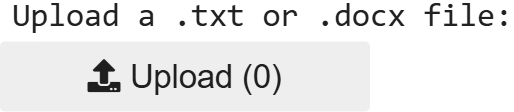



#### Please note that:
Accepted formats: .docx or .txt only

Recommended length: ≤ 500 words for fastest processing

Files outside these limits or formats may raise errors.

#### When everything runs correctly, you’ll see this exact confirmation:

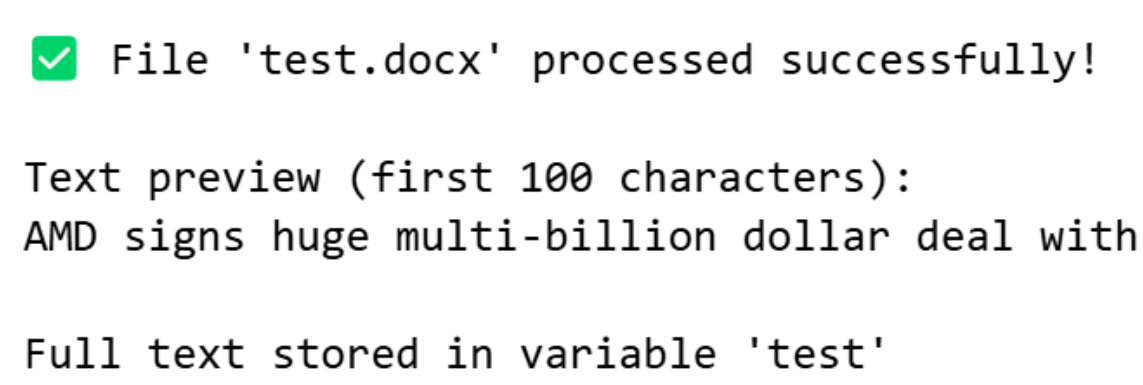



In [48]:
#Create file upload widget
uploader = widgets.FileUpload(
    accept='.txt,.docx',  # Accepted file types
    multiple=False  # Single file upload
)

output_area = widgets.Output()

def handle_upload(change):
    with output_area:
        clear_output()
        
        if not uploader.value:
            print("No file uploaded")
            return
            
        # Universal approach for all ipywidgets versions
        if hasattr(uploader.value, 'keys'):
            # Dictionary format (newer versions)
            filename = list(uploader.value.keys())[0]
            file_data = uploader.value[filename]
            content = file_data['content']
        elif isinstance(uploader.value, tuple) and len(uploader.value) > 0:
            # Tuple format (older versions)
            filename = uploader.value[0]['name']
            content = uploader.value[0]['content']
        else:
            print("Unsupported file format")
            return
        
        # Convert content to bytes if needed
        if isinstance(content, memoryview):
            content = content.tobytes()
            
        # Process based on file type
        if filename.endswith('.txt'):
            # Decode text file
            try:
                text = content.decode('utf-8')
            except UnicodeDecodeError:
                # Try alternative encodings if UTF-8 fails
                try:
                    text = content.decode('latin-1')
                except:
                    print("Failed to decode text file")
                    return
            
        elif filename.endswith('.docx'):
            # Process DOCX file
            try:
                doc = docx.Document(BytesIO(content))
                text = '\n'.join([para.text for para in doc.paragraphs])
            except:
                print("Failed to process DOCX file")
                return
            
        else:
            print("Unsupported file type")
            return
        
        # Clean and store text
        global test
        test = " ".join(text.split())  # Normalize whitespace
        
        # Show success message and preview
        print(f"✅ File '{filename}' processed successfully!")
        print("\nText preview (first 100 characters):")
        print(test[:100] + ("..." if len(test) > 100 else ""))
        print("\nFull text stored in variable 'test'")

# Setup interaction
uploader.observe(handle_upload, names='value')

# Display widgets
print("Upload a .txt or .docx file:")
display(uploader)
display(output_area)

Upload a .txt or .docx file:


FileUpload(value=(), accept='.txt,.docx', description='Upload')

Output()

#### Cotinue running the following cells once the file uploaded.Please review the contents of the file you just uploaded to ensure they match your expectations.



In [49]:
print(test[:200])  # View first 200 characters
len(test)          # Check text length

AMD signs huge multi-billion dollar deal with Oracle to build a cluster of 30,000 MI355X AI accelerators While AI darling Nvidia continues to dominate the AI accelerator market, with a share of over 9


1974

#### Generate the summary of the information included. 



In [50]:
print("Summary:", summarize_long(test))

Summary: The MI355X will be available in OAM and PCIe form factors. The OAM version will have 288GB of HBM3E memory (up from 192GB on the MI325X), 8TB/sec bandwidth (up from 6TB/sec), and 1.5X the compute density. The PCIe version will have 144GB of HBM3E (up from 96GB), 4TB/sec bandwidth (up from 3.2TB/sec), and 1.5X the compute density. The MI355X will be available in


## Congratulations! You are all done!
